<a href="https://colab.research.google.com/github/varsenii/AI/blob/main/Covid-19%20multimodal%20classification/numerical_feature_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pymrmr
!pip install -U imbalanced-learn
!pip install plot_keras_history
!pip install -U keras-tuner

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.7/dist-packages (0.8.0)
Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import json

import pymrmr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTEN, SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras.regularizers import l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import kerastuner as kt
from kerastuner import Objective


import seaborn as sns
from plot_keras_history import plot_history

In [ ]:
%cd "/content/drive/MyDrive/Programming/Machine Learning/Covid multimodal classification"

/content/drive/MyDrive/Programming/Machine Learning/Covid multimodal classification


In [ ]:
SEED = 42

# Data exploration

In [ ]:
df = pd.read_excel('./data/iCTCF/imputed_data_dec_True.xlsx')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Columns: 253 entries, id to Unnamed: 252
dtypes: float64(40), int64(209), object(4)
memory usage: 2.9+ MB
None


,id,Label1-Mortality outcome,Label2-SARS-CoV-2 nucleic acids,Age,Body temperature,Gender,Dementia,Brain surgery,Brain stem hemorrhage,Cerebral atherosclerosis,Cerebral hemorrhage,Cerebral infarction,Intracranial aneurysm,Lacunar infarction,Aphasia,Organic mental disorders,Pituitary adenoma,Subdural effusion,Subdural hemorrhage,Parkinson Disease,Encephalopathy,Myasthenia gravis,Gastrointestinal surgery for neoplasia,Adjuvant Chemotherapy for gastrointestinal tumor,Intestinal obstruction,Radio-chemotherapy,Gastritis,Non specified chronic stomach disease,Gastrointestinal bleeding,Gastrointestinal Ulcer,Gastroesophageal reflux,Gastric cancer,Inguinal hernia,Gastrointestinal surgery,Arrhythmia,Coronary disease,Heart failure,Cardiomyopathy,Hypertension,Hypertensive heart disease,...,TT Value in range,FIB Value,FIB Value in range,APTT Value,APTT Value in range,INR Value,INR Value in range,PT Value,PT Value in range,ALP Value,ALP Value in range,ALT Value,ALT Value in range,AST Value,AST Value in range,CA Value,CA Value in range,CL Value,CL Value in range,CO2 Value,CO2 Value in range,CREA Value,CREA Value in range,GLB Value,GLB Value in range,K Value,K Value in range,MG Value,MG Value in range,Na Value,Na Value in range,PHOS Value,PHOS Value in range,TBIL Value,TBIL Value in range,TP Value,TP Value in range,URIC Value,URIC Value in range,Unnamed: 252
0,Patient_1,Cured,Positive,81,36.6,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1.230000,1,0.677419,0,0.607843,0,0.6200,0,0.109091,0,1.657143,1,1.125000,1,0.098039,0,0.483333,0,0.988889,0,0.340449,0,0.90000,0,0.382353,0,0.600000,0,0.566667,0,0.015152,0,0.338129,0,-0.015789,-1,0.299091,0,78
1,Patient_2,Cured,Positive,50,38.7,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1.410000,1,1.012903,1,0.215686,0,0.2000,0,-0.036364,-1,1.285714,1,1.156250,1,0.509804,0,0.325000,0,-0.422222,-1,0.349438,0,0.59000,0,0.482353,0,0.275000,0,0.244444,0,0.545455,0,0.316547,0,0.147368,0,0.610455,0,78
2,Patient_3,Cured,Positive,65,38.5,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.635400,0,0.601679,0,0.467386,0,0.4800,0,0.036364,0,1.542857,1,1.718750,1,-0.509804,-1,0.750000,0,0.255556,0,0.269663,0,1.21000,1,0.076471,0,0.450000,0,0.622222,0,0.090909,0,-0.028777,-1,-0.100000,-1,0.402727,0,78
3,Patient_4,Cured,Positive,73,38.5,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1.385000,1,0.696774,0,0.274510,0,0.2800,0,0.236364,0,0.857143,0,1.218750,1,0.039216,0,0.350000,0,0.100000,0,0.424719,0,0.64000,0,0.682353,0,0.275000,0,0.133333,0,-0.348485,-1,0.323741,0,-0.310526,-1,0.155909,0,78
4,Patient_5,Cured,Positive,64,38.0,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.753367,0,0.521526,0,0.490196,0,0.5000,0,0.225305,0,0.335347,0,0.373590,0,0.267801,0,0.498645,0,0.382378,0,0.158858,0,0.53385,0,0.276455,0,0.369435,0,0.359689,0,0.266818,0,0.433222,0,-0.079335,-1,0.292060,0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,Patient_1517,Unknown,Positive,45,38.9,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2.380000,1,0.935484,0,0.823529,0,0.8400,0,0.172727,0,2.600000,1,1.125000,1,0.117647,0,0.341667,0,0.511111,0,0.096629,0,1.22000,1,0.629412,0,0.675000,0,0.333333,0,0.227273,0,0.251799,0,0.121053,0,-0.049545,-1,78
1517,Patient_1518,Unknown,Positive,66,36.6,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.649833,0,0.519263,0,0.490196,0,0.5000,0,0.273770,0,0.516920,0,0.423088,0,0.397199,0,0.489244,0,0.539678,0,0.211200,0,0.40990,0,0.342931,0,0.403222,0,0.362956,0,0.241364,0,0.406898,0,-0.190209,-1,0.339020,0,78
1

# Data preprocessing

In [ ]:
def prepare_df():
  df = pd.read_excel('./data/iCTCF/imputed_data_dec_True.xlsx')

  df['Label2-SARS-CoV-2 nucleic acids'].replace(to_replace={'Positive':1, 'Negative':0}, inplace=True)
  df['Gender'].replace(to_replace={'Female':0, 'Male':1}, inplace=True)

  df.drop(columns=[c for c in df.columns if 'Value in range' in c], inplace=True)
  df.drop(columns=['Unnamed: 252', 'id', 'Label1-Mortality outcome'], inplace=True)

  numerical_cols = []
  for c in df.columns:
    if df[c].dtype == 'float64' or c == "Age" or c == "Label2-SARS-CoV-2 nucleic acids":
        numerical_cols.append(c)
  return df[numerical_cols]

df = prepare_df()
df

,Label2-SARS-CoV-2 nucleic acids,Age,Body temperature,MCH Value,MCV Value,HCT Value,HGB Value,RBC Value,PDW Value,PLCT Value,MPV Value,PLT Value,EO Value,MO Value,LY Value,NE Value,BAP Value,EOP Value,MOP Value,LYP Value,NEP Value,WBC Value,TT Value,FIB Value,APTT Value,INR Value,PT Value,ALP Value,ALT Value,AST Value,CA Value,CL Value,CO2 Value,CREA Value,GLB Value,K Value,MG Value,Na Value,PHOS Value,TBIL Value,TP Value,URIC Value
0,1,81,36.6,0.600000,0.483333,-0.42,-0.155556,-0.240000,0.384615,0.888889,0.125,0.795556,0.10,0.22,-0.047619,-0.148889,0.30,0.355263,0.814286,0.706667,0.191429,-0.180000,0.457143,1.230000,0.677419,0.607843,0.6200,0.109091,1.657143,1.125000,0.098039,0.483333,0.988889,0.340449,0.90000,0.382353,0.600000,0.566667,0.015152,0.338129,-0.015789,0.299091
1,1,50,38.7,0.642857,0.455556,0.15,0.333333,0.200000,-2.538462,0.222222,0.625,0.040000,-0.04,-0.02,-0.209524,-0.133333,0.00,-0.052632,0.228571,0.460000,0.617143,-0.258333,0.642857,1.410000,1.012903,0.215686,0.2000,-0.036364,1.285714,1.156250,0.509804,0.325000,-0.422222,0.349438,0.59000,0.482353,0.275000,0.244444,0.545455,0.316547,0.147368,0.610455
2,1,65,38.5,0.585714,0.677778,-0.96,-0.644444,-0.713333,0.307692,0.555556,0.700,0.257778,-0.04,0.40,-0.200000,0.268889,0.40,-0.039474,0.642857,-0.103333,1.002857,0.085000,0.304143,0.635400,0.601679,0.467386,0.4800,0.036364,1.542857,1.718750,-0.509804,0.750000,0.255556,0.269663,1.21000,0.076471,0.450000,0.622222,0.090909,-0.028777,-0.100000,0.402727
3,1,73,38.5,0.528571,0.516667,0.09,0.177778,0.120000,0.230769,0.722222,0.075,0.653333,-0.04,0.40,-0.176190,0.531111,0.60,-0.052632,0.400000,-0.203333,1.134286,0.291667,0.728571,1.385000,0.696774,0.274510,0.2800,0.236364,0.857143,1.218750,0.039216,0.350000,0.100000,0.424719,0.64000,0.682353,0.275000,0.133333,-0.348485,0.323741,-0.310526,0.155909
4,1,64,38.0,0.485714,0.577778,0.15,0.133333,0.126667,0.384615,0.555556,0.275,0.400000,-0.04,0.66,0.257143,0.762222,0.10,-0.052632,0.414286,0.080000,0.902857,0.635000,0.310286,0.753367,0.521526,0.490196,0.5000,0.225305,0.335347,0.373590,0.267801,0.498645,0.382378,0.158858,0.53385,0.276455,0.369435,0.359689,0.266818,0.433222,-0.079335,0.292060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,1,45,38.9,0.442857,0.394444,-0.42,-0.200000,-0.186667,-3.076923,1.500000,0.625,1.013333,0.16,0.68,0.161905,0.093333,0.50,0.263158,1.057143,0.470000,0.360000,0.120000,0.785714,2.380000,0.935484,0.823529,0.8400,0.172727,2.600000,1.125000,0.117647,0.341667,0.511111,0.096629,1.22000,0.629412,0.675000,0.333333,0.227273,0.251799,0.121053,-0.049545
1517,1,66,36.6,0.628571,0.694444,-0.54,-0.333333,-0.426667,0.461538,0.666667,-0.175,0.760000,0.16,0.96,0.700000,0.206667,1.20,0.155263,0.932857,0.753333,0.146571,0.425000,0.517714,0.649833,0.519263,0.490196,0.5000,0.273770,0.516920,0.423088,0.397199,0.489244,0.539678,0.211200,0.40990,0.342931,0.403222,0.362956,0.241364,0.406898,-0.190209,0.339020
1518,1,71,36.6,0.871429,0.866667,-0.65,-0.355556,-0.573333,0.076923,0.277778,0.525,0.124444,0.06,0.86,0.328571,-0.037778,0.55,0.102632,1.460000,0.816667,0.017143,0.086667,0.344714,0.625817,0.582131,0.490196,0.5035,0.195800,0.399279,0.382485,0.375322,0.658242,0.449411,0.163086,0.43810,0.276664,0.390500,0.519900,0.339545,0.372071,-0.164926,0.286937
1519,1,66,36.6,0.457143,0.616667,-0.55,-0.400000,-0.393333,1.076923,0.777778,-0.125,0.866667,0.22,0.68,0.100000,0.326667,0.27,0.282895,0.800000,0.176667,0.665714,0.278333,0.338000,0.726683,0.489154,0.481029,0.5000,0.357797,0.348387,0.321123,0.271148,0.472341,0.464611,0.129051,0.56740,0.306998,0.406806,0.291956,0.286515,0.361796,-0.139725,0.218743


## Normilization

In [ ]:
def normilize_data(X_train, X_val, X_test):
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)
  X_test = scaler.transform(X_test)
  return X_train, X_val, X_test

## Feature Selection

In [ ]:
def select_best_features(df, k = len(df.columns) // 2):
  selected_features = pymrmr.mRMR(df, 'MIQ', k)
  df = pd.concat((df['Label2-SARS-CoV-2 nucleic acids'], df[selected_features]), axis = 1)
  return df

select_best_features(df)

,Label2-SARS-CoV-2 nucleic acids,Body temperature,HGB Value,URIC Value,FIB Value,LY Value,TT Value,EOP Value,MOP Value,ALP Value,TP Value,MG Value,LYP Value,HCT Value,PHOS Value,ALT Value,Age,RBC Value,EO Value,INR Value,CREA Value,PDW Value
0,1,36.6,-0.155556,0.299091,1.230000,-0.047619,0.457143,0.355263,0.814286,0.109091,-0.015789,0.600000,0.706667,-0.42,0.015152,1.657143,81,-0.240000,0.10,0.607843,0.340449,0.384615
1,1,38.7,0.333333,0.610455,1.410000,-0.209524,0.642857,-0.052632,0.228571,-0.036364,0.147368,0.275000,0.460000,0.15,0.545455,1.285714,50,0.200000,-0.04,0.215686,0.349438,-2.538462
2,1,38.5,-0.644444,0.402727,0.635400,-0.200000,0.304143,-0.039474,0.642857,0.036364,-0.100000,0.450000,-0.103333,-0.96,0.090909,1.542857,65,-0.713333,-0.04,0.467386,0.269663,0.307692
3,1,38.5,0.177778,0.155909,1.385000,-0.176190,0.728571,-0.052632,0.400000,0.236364,-0.310526,0.275000,-0.203333,0.09,-0.348485,0.857143,73,0.120000,-0.04,0.274510,0.424719,0.230769
4,1,38.0,0.133333,0.292060,0.753367,0.257143,0.310286,-0.052632,0.414286,0.225305,-0.079335,0.369435,0.080000,0.15,0.266818,0.335347,64,0.126667,-0.04,0.490196,0.158858,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,1,38.9,-0.200000,-0.049545,2.380000,0.161905,0.785714,0.263158,1.057143,0.172727,0.121053,0.675000,0.470000,-0.42,0.227273,2.600000,45,-0.186667,0.16,0.823529,0.096629,-3.076923
1517,1,36.6,-0.333333,0.339020,0.649833,0.700000,0.517714,0.155263,0.932857,0.273770,-0.190209,0.403222,0.753333,-0.54,0.241364,0.516920,66,-0.426667,0.16,0.490196,0.211200,0.461538
1518,1,36.6,-0.355556,0.286937,0.625817,0.328571,0.344714,0.102632,1.460000,0.195800,-0.164926,0.390500,0.816667,-0.65,0.339545,0.399279,71,-0.573333,0.06,0.490196,0.163086,0.076923
1519,1,36.6,-0.400000,0.218743,0.726683,0.100000,0.338000,0.282895,0.800000,0.357797,-0.139725,0.406806,0.176667,-0.55,0.286515,0.348387,66,-0.393333,0.22,0.481029,0.129051,1.076923


# Deal with imbalances data



In [ ]:
df['Label2-SARS-CoV-2 nucleic acids'].value_counts()

1    945
0    576
Name: Label2-SARS-CoV-2 nucleic acids, dtype: int64

## Class Weighing

In [ ]:
y = df['Label2-SARS-CoV-2 nucleic acids']
print(y.value_counts().to_string())

neg_count = sum(y == 0)
pos_count = sum(y == 1)
neg_weight = pos_count / neg_count
pos_weight = 1.0
weights = {0: neg_weight, 1: pos_weight}

weights

1    945
0    576


{0: 1.640625, 1: 1.0}

## Undersampling

In [ ]:
neg_df = df[df['Label2-SARS-CoV-2 nucleic acids'] == 0]
pos_df = df[df['Label2-SARS-CoV-2 nucleic acids'] == 1][:len(neg_df)]
df = pd.concat([neg_df, pos_df], axis=0)
df['Label2-SARS-CoV-2 nucleic acids'].value_counts()

1    576
0    576
Name: Label2-SARS-CoV-2 nucleic acids, dtype: int64

## Oversampling

In [ ]:
positive = df[df['Label2-SARS-CoV-2 nucleic acids'] == 1]
negative = df[df['Label2-SARS-CoV-2 nucleic acids'] == 0]
negative = resample(negative, n_samples = len(positive))
df = positive.append(negative)
df.sample(frac = 1)

df['Label2-SARS-CoV-2 nucleic acids'].value_counts()

1    945
0    945
Name: Label2-SARS-CoV-2 nucleic acids, dtype: int64

### SMOTE

In [ ]:
def smote_oversampling(X, y, random_state = 42):
  sampler = SMOTE(random_state = random_state)
  X_oversampled, y_oversampled = sampler.fit_resample(X, y)
  return X_oversampled, y_oversampled

# Hyperparameter Optimization

In [ ]:
df = prepare_df()
df = select_best_features(df, k = 30)
y = df['Label2-SARS-CoV-2 nucleic acids'].values
X = df.drop('Label2-SARS-CoV-2 nucleic acids', axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = SEED,
                                                    stratify = y)
scalar = MinMaxScaler()
X_train  = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)

# X_train, y_train = oversample(X_train, y_train)

data_dim = X.shape[1]
data_dim

30

In [ ]:
class Tuner(kt.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value = 8, max_value = 512, 
                                                     step = 32, default = 232)
    super().run_trial(trial, *args, **kwargs)

In [ ]:
def create_hypermodel(hp):
  tf.random.set_seed(SEED)

  input = x = Input(shape = (data_dim, ))

  for i in range(hp.Int('num_layers', min_value = 1, max_value = 5, default = 1)):
    x = Dense(
        units = hp.Int('units_' + str(i), min_value = 32, max_value = 256, step = 16, default = 128),
        activation = hp.Choice('activation', ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid',
                                              'hard_sigmoid', 'linear'], default = 'relu'),
        kernel_initializer = hp.Choice('weight_init', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                       'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                                       default = 'glorot_uniform'),
        kernel_constraint = max_norm(max_value = hp.Choice('weight_constraint', [1, 2, 3, 4, 5], 
                                                           default = None))

    )(x)
    x = Dropout(
        rate = hp.Float('drop_rate_' + str(i), min_value = 0.0, max_value = 0.9, step = 0.1, default = 0.0)
    )(x)

  output = Dense(1, 'sigmoid')(x)
  model = Model(input, output)

  lr = hp.Float('lr', min_value = 1e-6, max_value = 1e-1, default = 1e-2)
  decay = hp.Float('decay', min_value = 1e-6, max_value = 1e-2, default = 1e-07)
  model.compile(
      optimizer = Adam(lr, decay = decay),
      loss = 'binary_crossentropy',
      metrics = ['accuracy', AUC(), f1_score]
  )
  return model

In [ ]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [ ]:
# OBJECTIVE = Objective('val_f1_score', direction = 'max')
OBJECTIVE = Objective('auc', direction = 'max')

MAX_TRIALS = 300
EXECUTIONS_PER_TRIAL = 1

callbacks = [
               EarlyStopping(
                   monitor = 'val_auc',
                   patience = 10,
                   mode = 'max',
                   restore_best_weights = True
               )
  ]

## Architecture, Learning Rate and Decay

In [ ]:
hp = kt.HyperParameters()
# hp.Fixed('num_layers', 3)
hp.Fixed('activation', 'relu')
hp.Fixed('weight_init', 'glorot_uniform')
hp.Fixed('weight_constraint', 1000)

tuner = Tuner(
    create_hypermodel,
    objective = OBJECTIVE,
    hyperparameters = hp,
    tune_new_entries = True,
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTIONS_PER_TRIAL,
    seed = SEED,
    directory = 'tuning/numerical_clinical_features/',
    project_name = 'architecture_adam'
)

tuner.search_space_summary()

Search space summary
Default search space size: 8
activation (Fixed)
{'conditions': [], 'value': 'relu'}
weight_init (Fixed)
{'conditions': [], 'value': 'glorot_uniform'}
weight_constraint (Fixed)
{'conditions': [], 'value': 1000}
num_layers (Int)
{'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
drop_rate_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 0.01, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.1, 'step': None, 'sampling': None}
decay (Float)
{'default': 1e-07, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': None}


In [ ]:
tuner.search(
    X_train,
    y_train,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = callbacks,
    verbose = 2
)

Trial 300 Complete [00h 00m 12s]
auc: 0.7526440620422363

Best auc So Far: 0.8124094009399414
Total elapsed time: 01h 54m 51s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.get_best_models()[0]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 8,193
Trainable params: 8,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner.results_summary()

Results summary
Results in tuning/numerical_clinical_features/architecture_adam
Showing 10 best trials
Objective(name='auc', direction='max')
Trial summary
Hyperparameters:
activation: relu
weight_init: glorot_uniform
weight_constraint: 1000
num_layers: 1
units_0: 256
drop_rate_0: 0.0
lr: 0.014431506611266036
decay: 0.003632025496580903
batch_size: 8
units_1: 32
drop_rate_1: 0.0
units_2: 256
drop_rate_2: 0.5
units_3: 32
drop_rate_3: 0.0
units_4: 32
drop_rate_4: 0.9
Score: 0.8124094009399414
Trial summary
Hyperparameters:
activation: relu
weight_init: glorot_uniform
weight_constraint: 1000
num_layers: 1
units_0: 256
drop_rate_0: 0.0
lr: 0.021206257281828646
decay: 0.0033546510746300237
batch_size: 8
units_1: 256
drop_rate_1: 0.0
units_2: 256
drop_rate_2: 0.0
units_3: 32
drop_rate_3: 0.5
units_4: 256
drop_rate_4: 0.30000000000000004
Score: 0.8117408156394958
Trial summary
Hyperparameters:
activation: relu
weight_init: glorot_uniform
weight_constraint: 1000
num_layers: 1
units_0: 160
drop

## Dropout and Weight Constraint

In [ ]:
hp = kt.HyperParameters()
for i in range(3):
  hp.Float('drop_rate_' + str(i + 1), min_value = 0.0, max_value = 0.9, step = 0.1, default = 0.0)
hp.Choice('weight_constraint', [1, 2, 3, 4, 5], default = 5)

tuner = Tuner(
    clinical_data_hypermodel,
    objective = OBJECTIVE,
    hyperparameters = hp,
    tune_new_entries = False,
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTIONS_PER_TRIAL,
    seed = SEED,
    directory = 'tuning/clinical_data/',
    project_name = 'drop rate and weight constraint'
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
drop_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
drop_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
drop_rate_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
weight_constraint (Choice)
{'default': 5, 'conditions': [], 'values': [1, 2, 3, 4, 5], 'ordered': True}


In [ ]:
tuner.search(
    X_train,
    y_train,
    epochs = 200,
    validation_data = (X_test, y_test),
    callbacks = callbacks,
    verbose = 1
)

Trial 200 Complete [00h 00m 08s]
val_f1_score: 0.06315789222717286

Best val_f1_score So Far: 0.395203572511673
Total elapsed time: 00h 34m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in tuning/clinical_data/drop rate and weight constraint
Showing 10 best trials
Objective(name='val_f1_score', direction='max')
Trial summary
Hyperparameters:
drop_rate_1: 0.9
drop_rate_2: 0.9
drop_rate_3: 0.5
weight_constraint: 1
batch_size: 104
num_layers: 3
units_0: 120
activation: relu
weight_init: glorot_uniform
units_1: 120
units_2: 120
lr: 0.001
decay: 0.001
Score: 0.395203572511673
Trial summary
Hyperparameters:
drop_rate_1: 0.0
drop_rate_2: 0.9
drop_rate_3: 0.9
weight_constraint: 1
batch_size: 104
num_layers: 3
units_0: 120
activation: relu
weight_init: glorot_uniform
units_1: 120
units_2: 120
lr: 0.001
decay: 0.001
Score: 0.3911110758781433
Trial summary
Hyperparameters:
drop_rate_1: 0.7000000000000001
drop_rate_2: 0.9
drop_rate_3: 0.9
weight_constraint: 3
batch_size: 104
num_layers: 3
units_0: 120
activation: relu
weight_init: glorot_uniform
units_1: 120
units_2: 120
lr: 0.001
decay: 0.001
Score: 0.38547616004943847
Trial summary
Hyperparameters:
drop_

## Weight Initialization

In [ ]:
def tune_init_weights(hp):
  init_weights = hp.Choice('init_weights', ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal',
                                  'glorot_uniform', 'he_normal', 'he_uniform']
  )

  input = x = Input(shape = (42, ))
  x = Dense(units = 120, activation = 'relu', kernel_initializer = init_weights, )(x)
  x = Dense(1, activation = 'sigmoid', kernel_initializer = init_weights)(x)
  model = Model(inputs = input, outputs = x)

  model.compile(
    optimizer = Adam(0.01),
    loss = "binary_crossentropy",
    metrics = [f1_score, 'Precision', 'Recall'] 
  )
  return model

In [ ]:
tuner = kt.BayesianOptimization(
    tune_init_weights,
    objective = OBJECTIVE,
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTIONS_PER_TRIAL,
    directory = 'tuning',
    project_name = 'tune_init_weights'
)

tuner.search_space_summary()

Search space summary
Default search space size: 1
init_weights (Choice)
{'default': 'uniform', 'conditions': [], 'values': ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'], 'ordered': False}


In [ ]:
tuner.search(
    X_train,
    y_train,
    epochs = 200,
    validation_data = (X_test, y_test),
    callbacks = callbacks,
    verbose = 2
)

Trial 20 Complete [00h 00m 14s]
val_f1_score: 0.5714285373687744

Best val_f1_score So Far: 0.6042856812477112
Total elapsed time: 00h 05m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in tuning/tune_init_weights
Showing 10 best trials
Objective(name='val_f1_score', direction='max')
Trial summary
Hyperparameters:
init_weights: he_normal
Score: 0.6042856812477112
Trial summary
Hyperparameters:
init_weights: glorot_uniform
Score: 0.6035714149475098
Trial summary
Hyperparameters:
init_weights: he_uniform
Score: 0.601190447807312
Trial summary
Hyperparameters:
init_weights: glorot_normal
Score: 0.601190447807312
Trial summary
Hyperparameters:
init_weights: glorot_normal
Score: 0.596218466758728
Trial summary
Hyperparameters:
init_weights: he_uniform
Score: 0.5928571224212646
Trial summary
Hyperparameters:
init_weights: glorot_normal
Score: 0.5928571224212646
Trial summary
Hyperparameters:
init_weights: he_uniform
Score: 0.5888655185699463
Trial summary
Hyperparameters:
init_weights: glorot_uniform
Score: 0.5855041742324829
Trial summary
Hyperparameters:
init_weights: glorot_normal
Score: 0.5855041742324829


# Model Saving/Loading

In [ ]:
def save_model(model, path = './saved models/clinical_data_model.h5'):
  dir = '/'.join(path.split('/')[:-1])
  if not os.path.exists(dir):
    os.makedirs(dir)
  model.save(path)

In [ ]:
def load_model(path = './saved models/clinical_data_model.h5', include_top = True):
  model = tf.keras.models.load_model(path,  custom_objects = {'f1_score': f1_score})
  if not include_top:
    model = Model(inputs = model.input,outputs = model.layers[-2].output)
  return model

In [ ]:
def save_weights(model, include_top = True, path = './saved weights/clinical_data_weights.h5'):
  dir = '/'.join(path.split('/')[:-1])
  if not os.path.exists(dir):
    os.makedirs(dir)
  if not include_top:
    model = Model(inputs = model.input,outputs = model.layers[-2].output)
  model.save_weights(path)

# Model evaluation

In [ ]:
def create_model(input_dim, seed = 42, compiled = True):
  tf.random.set_seed(SEED)

  input = x = Input(shape = (input_dim, ))
  x = Dense(128, activation = 'relu',)(x)
  x = Dense(1, activation = 'sigmoid', name = 'output')(x)
  model = Model(inputs = input, outputs = x)

  if compiled:
    model.compile(
      optimizer = Adam(learning_rate=0.01, decay = 1e-06),
      loss = "binary_crossentropy",
      metrics = ['accuracy', 'AUC', f1_score] 
    )
  return model

# def create_model(input_dim, seed = 42, compiled = True):
#   tf.random.set_seed(SEED)

#   input = x = Input(shape = (input_dim, ))
#   x = Dense(189, activation = 'relu',)(x)
#   # x = Dropout(0.1)(x)
#   x = Dense(1, activation = 'sigmoid', name = 'output')(x)
#   model = Model(inputs = input, outputs = x)

#   if compiled:
#     model.compile(
#       optimizer = Adam(learning_rate = 0.021660726134570093, decay = 0.00330727810302112),
#       loss = "binary_crossentropy",
#       metrics = ['accuracy', 'AUC', f1_score] 
#     )
#   return model

In [ ]:
def fit_model(model, X_train, X_val, y_train, y_val, epochs = 100, bs = 64, weights = None, verbose = 0):
  callbacks = [
               EarlyStopping(
                  #  monitor = 'val_auc',
                    monitor = 'val_accuracy',
                   min_delta = 0.0001,
                   patience = 10,
                   mode = 'max',
                   restore_best_weights = True
               )
  ]

  history = model.fit(
      x = X_train,
      y = y_train,
      epochs = epochs,
      batch_size = bs,
      validation_data = (X_val, y_val),
      validation_batch_size = bs,
      class_weight = weights,
      callbacks = callbacks,
      verbose = verbose
  ).history

  return history

In [ ]:
def f1_score(y_true, y_pred):
  def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

def show_cm(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  group_names = ['TN', 'FP', 'FN', 'TP']
  group_counts = [c for c in cm.flatten()]
  group_percentages = [f'{p:.2%}' for p in cm.flatten() / sum(cm.flatten())]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape((2, 2))
  classes = ['Negative', 'Positive']
  sns.heatmap(cm, cmap = 'Blues', annot = labels, fmt = '', xticklabels = classes, yticklabels = classes)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [ ]:
EPOCHS = 200
BS = 232

## K-Fold Cross-Validation

In [ ]:
df = prepare_df()
df = select_best_features(df, k = 30)
y = df['Label2-SARS-CoV-2 nucleic acids'].values
X = df.drop('Label2-SARS-CoV-2 nucleic acids', axis = 1).values
y

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
histories = []
ground_truth = []
y_prob = []
y_pred = []
cv_scores = []

skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)
for train_index, test_index in skf.split(X, y):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True, 
                                                        stratify = y_train, random_state = SEED)
  
  X_train, X_val, X_test = normilize_data(X_train, X_val, X_test)
  # X_train, y_train = smote_oversample(X_train, y_train, random_state = SEED)
  
  model = create_model(input_dim = X_train.shape[1], seed = SEED)

  history = fit_model(model, X_train, X_val, y_train, y_val, EPOCHS, BS, verbose = 0)
  histories.append(history)

  predicted = model.predict(X_test, batch_size = BS)
  y_prob.extend(predicted[:, 0])
  predicted = np.round(predicted[:, 0])
  y_pred.extend(predicted)
  ground_truth.extend(y_test)

  # scores = model.evaluate(X_test, y_test, verbose = 0)
  # cv_scores.append(scores)

In [ ]:
# for i, metric in enumerate(model.metrics_names):
#   print(f'{metric}:')
#   mean = np.mean(cv_scores[i])
#   sd = np.std(cv_scores[i])
#   print(f'mean - {mean}, sd - {sd}', end = '\n')

              precision    recall  f1-score   support

           0       0.63      0.49      0.55       576
           1       0.73      0.83      0.77       945

    accuracy                           0.70      1521
   macro avg       0.68      0.66      0.66      1521
weighted avg       0.69      0.70      0.69      1521



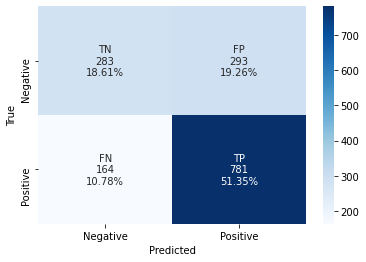

In [ ]:
# new
# y_pred = [1 if p > 0.51 else 0 for p in y_prob]
print(classification_report(y_true = ground_truth, y_pred = y_pred))
plt.show()
show_cm(ground_truth, y_pred)

              precision    recall  f1-score   support

    Negative       0.64      0.52      0.58       576
    Positive       0.74      0.82      0.78       945

    accuracy                           0.71      1521
   macro avg       0.69      0.67      0.68      1521
weighted avg       0.70      0.71      0.70      1521



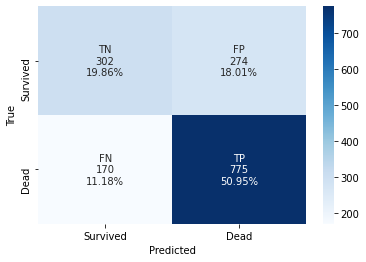

In [ ]:
# 30 best features

print(classification_report(y_true = ground_truth, y_pred = predicted, target_names = ['Negative', 'Positive']))
plt.show()
show_cm(ground_truth, predicted)

              precision    recall  f1-score   support

    Negative       0.73      0.33      0.45       576
    Positive       0.69      0.93      0.79       945

    accuracy                           0.70      1521
   macro avg       0.71      0.63      0.62      1521
weighted avg       0.71      0.70      0.66      1521



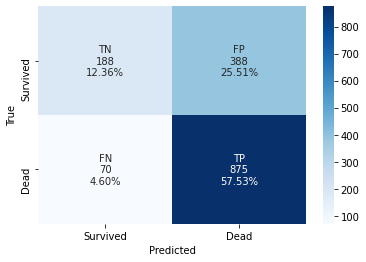

In [ ]:
# all data toghether
print(classification_report(y_true = ground_truth, y_pred = predicted, target_names = ['Negative', 'Positive']))
plt.show()
show_cm(ground_truth, predicted)

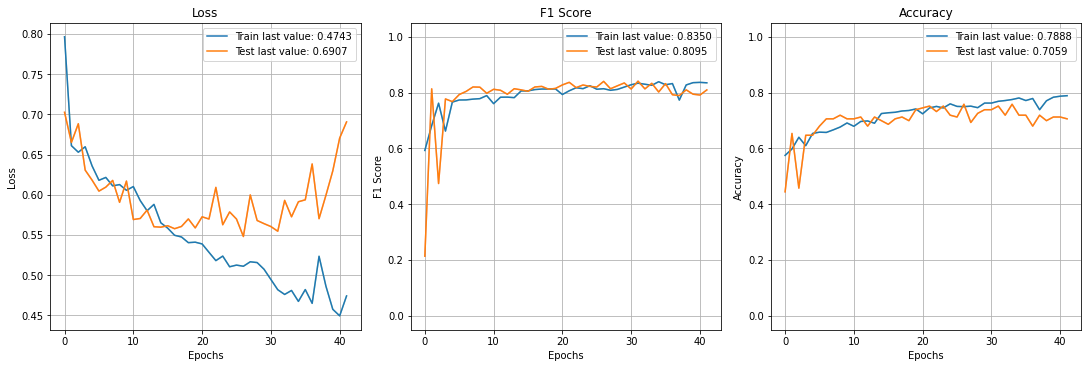

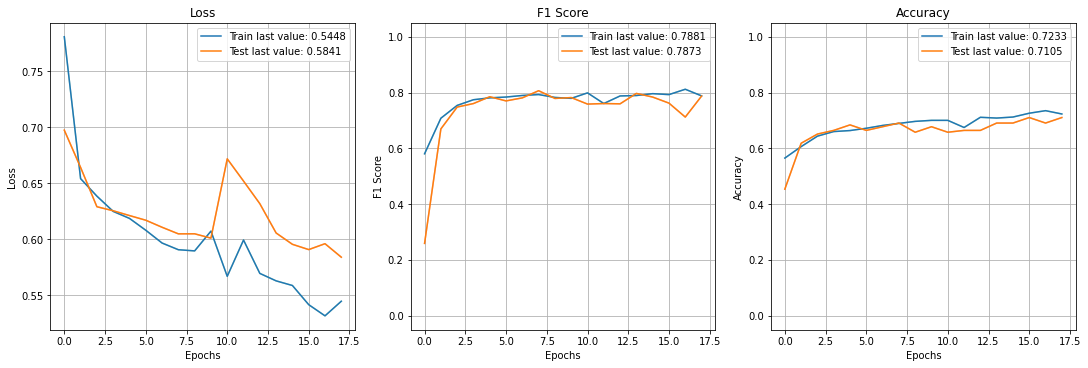

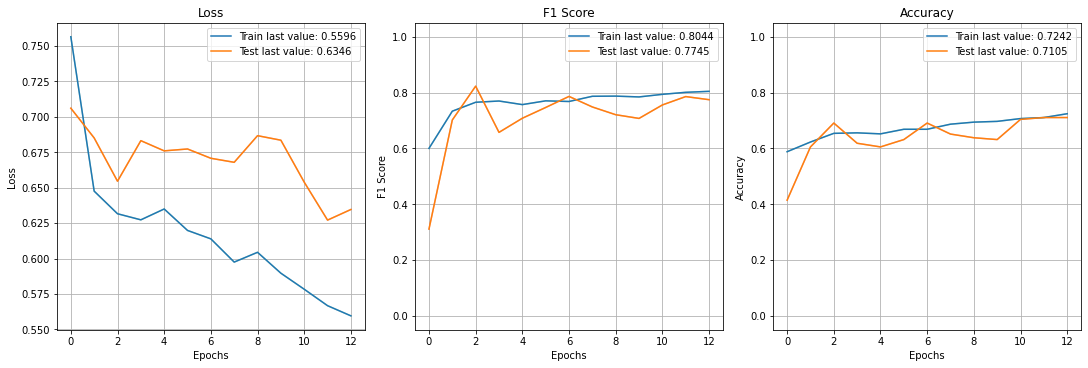

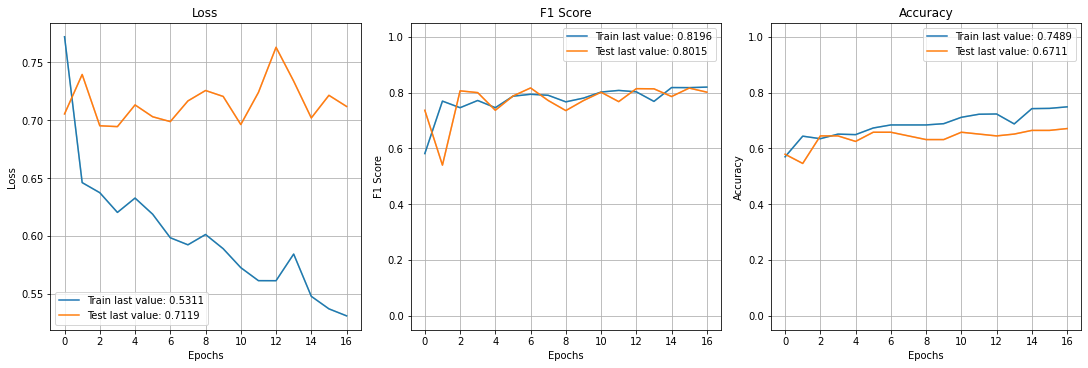

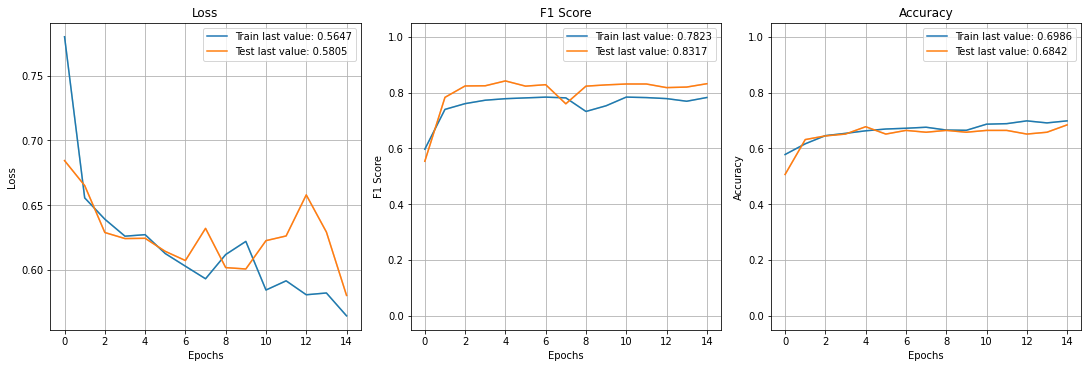

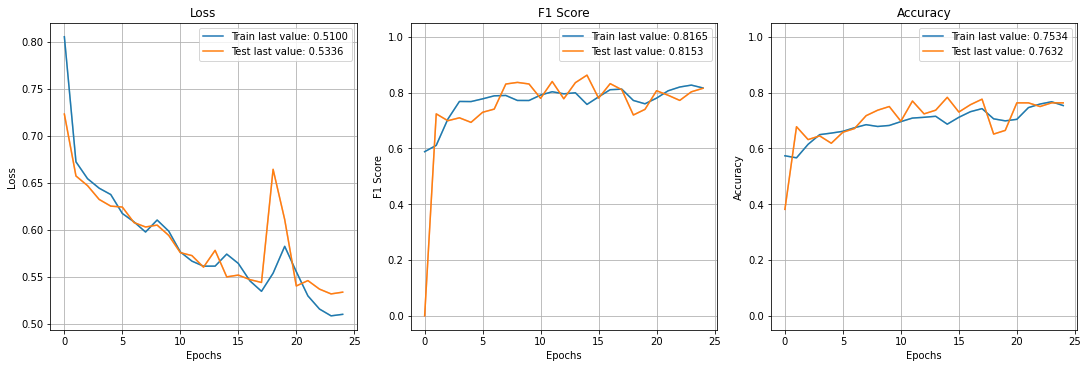

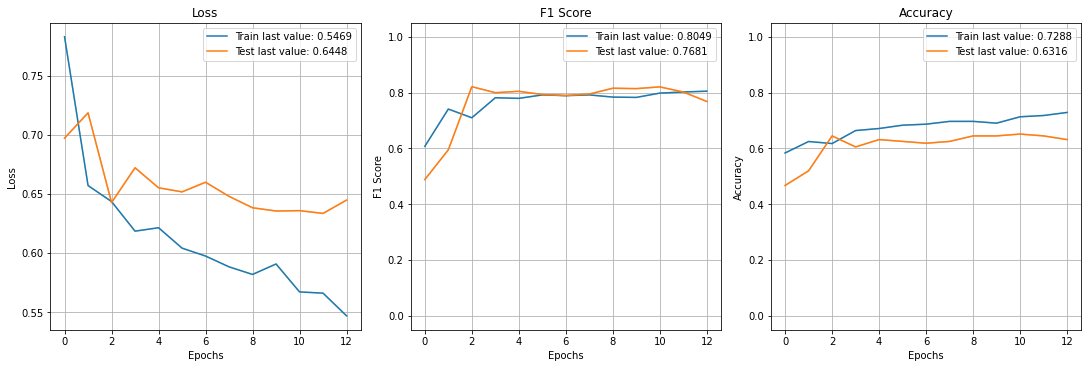

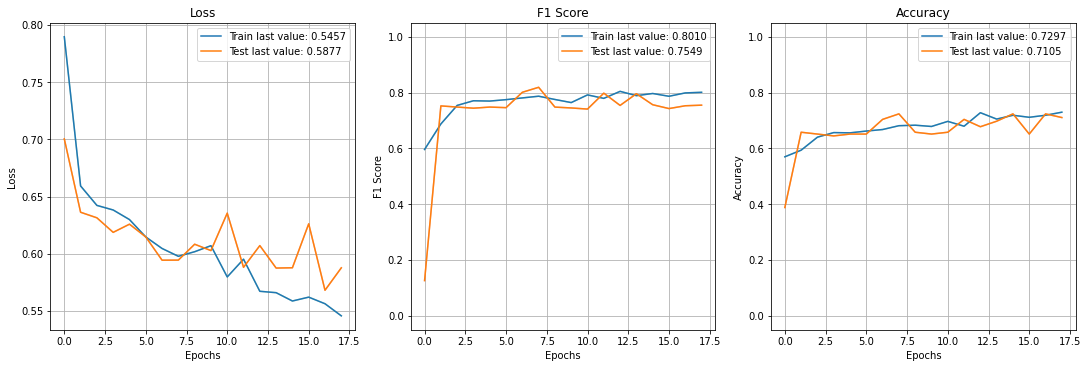

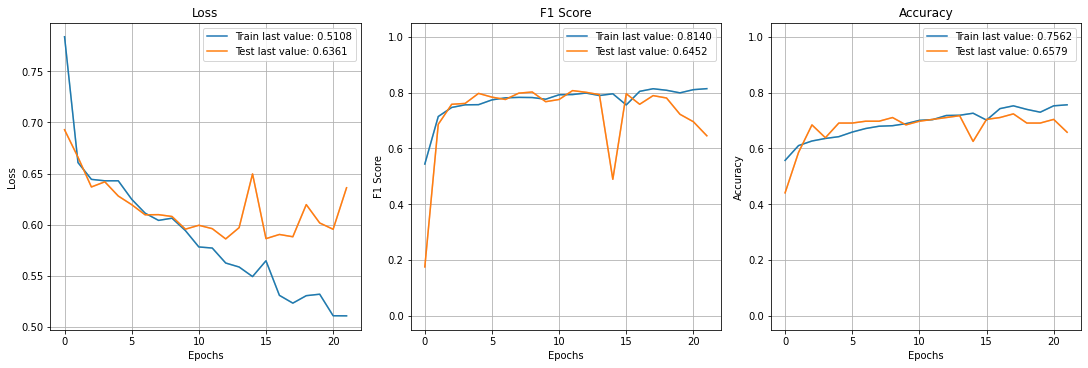

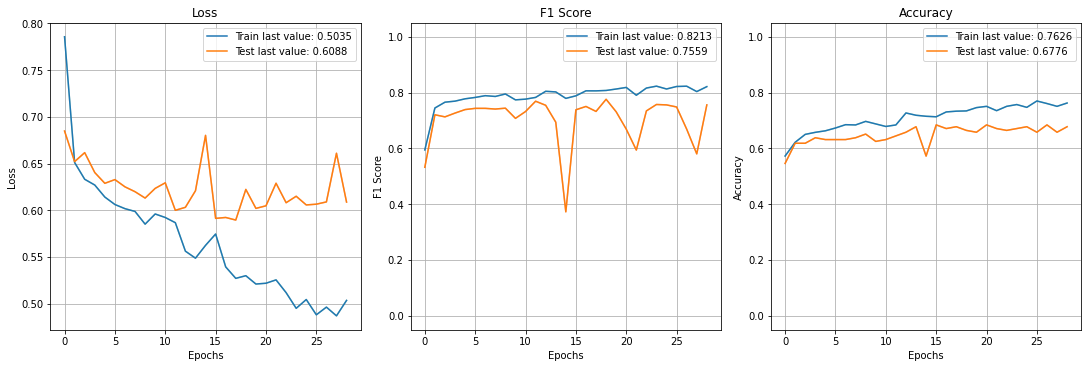

In [ ]:
for history in histories:
  plot_history(history)
  plt.show()

# Final Model

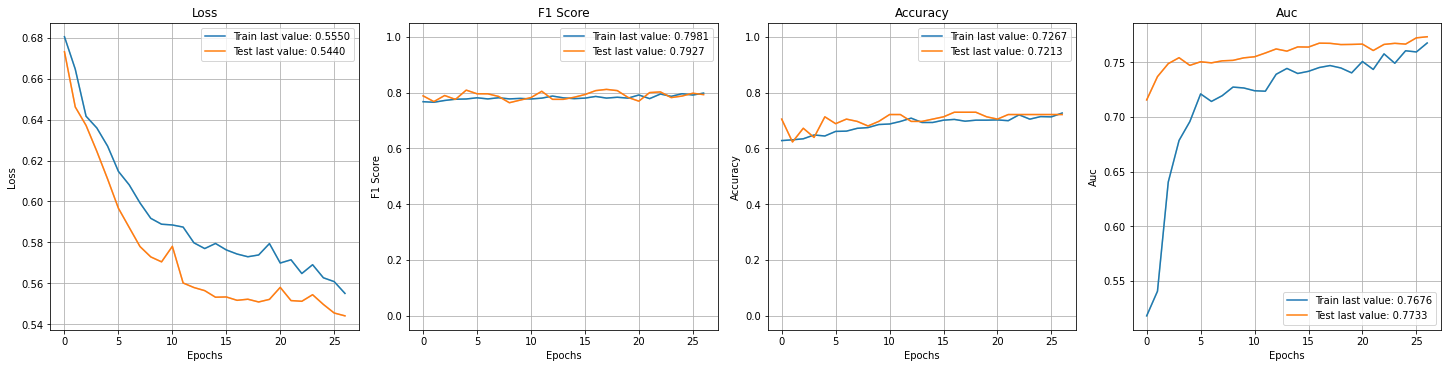

In [ ]:
df = prepare_df()
y = df['Label2-SARS-CoV-2 nucleic acids'].values
X = df.drop('Label2-SARS-CoV-2 nucleic acids', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = SEED,
                                                    stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, shuffle = True, 
                                                  random_state = SEED, stratify = y_train)
X_train, X_val, X_test = normilize_data(X_train, X_val, X_test)

model = create_model(input_dim = X_train.shape[1], seed = SEED)
# plot_model(model, to_file = 'clinical data model.png', show_shapes = True)

history = fit_model(model, X_train, X_val, y_train, y_val, EPOCHS, BS)
plot_history(history)
plt.show()

In [ ]:
y_pred = model.predict(X_test, batch_size = BS)
# y_pred = np.round(y_pred)
# print(classification_report(y_true = y_test, y_pred = y_pred, target_names = ['Negative', 'Positive']))
# plt.show()
y_pred = y_pred[:, 0]

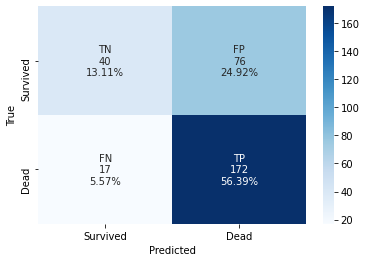

In [ ]:
show_cm(y_test, y_pred)

125

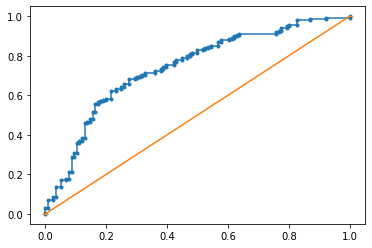

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
rnd_prob = [0 for _ in range(len(y_test))]
rnd_fpr, rnd_tpr, rnd_thresholds = roc_curve(y_test, rnd_prob)
plt.plot(fpr, tpr, marker = '.')
plt.plot(rnd_fpr, rnd_tpr, marker = '_')
len(thresholds)

In [ ]:
fpr

array([0.        , 0.63793103, 1.        ])

In [ ]:
roc_auc_score(y_test, y_pred)

0.6492884510125889

In [ ]:
save_model(model)